In [2]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### FitzHugh-Nagumo

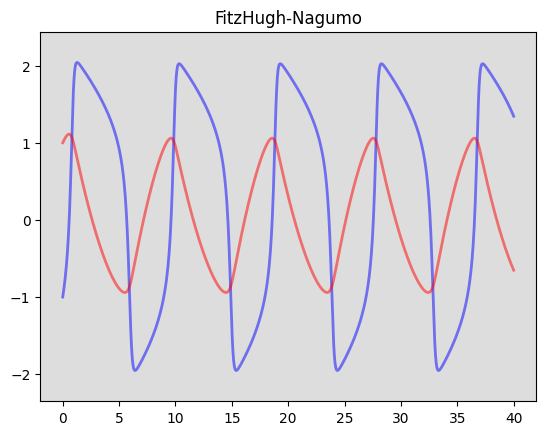

In [3]:
# define FitzHugh-Nagumo model dynamic
def FN(y, t, a, b, c):
	V, R = y
	dVdt = c * (V - np.power(V,3)/3.0 + R)
	dRdt = -1./c * (V - a + b*R)
	return (dVdt,dRdt)

# model parameters 
a, b, c = 0.2, 0.2, 3
# initial condition
V0 = -1
R0 = 1
y0 = V0, R0
# time point for evaluation
tdata = np.linspace(0, 40, 1281)
# integration
xdata = odeint(FN, y0, tdata, args = (a,b,c))
# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('FitzHugh-Nagumo')
plt.show()

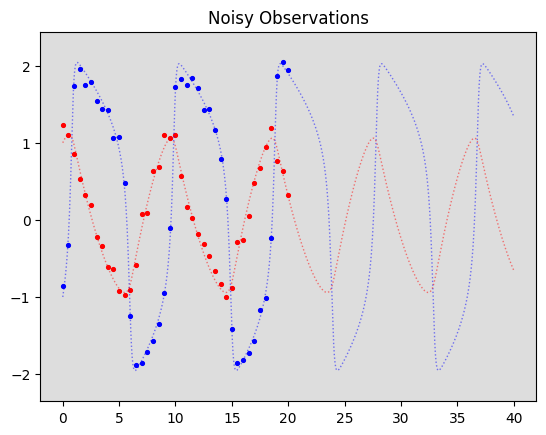

In [10]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [12]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2500,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2500 iteration: 39.367233
500/2500 iteration: 1.990714
1000/2500 iteration: 1.305106
1500/2500 iteration: 1.108004
2000/2500 iteration: 1.010481
2500/2500 iteration: 0.948814
run time: 26.67 seconds


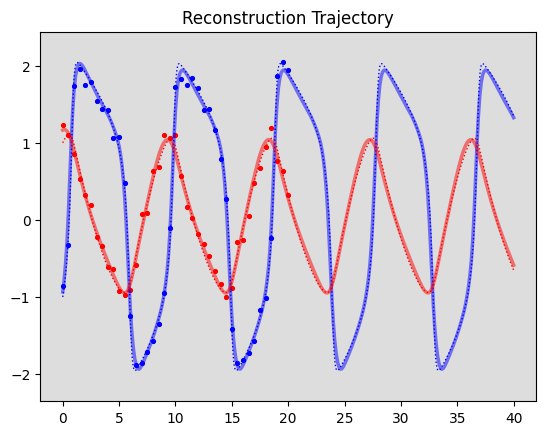

In [13]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

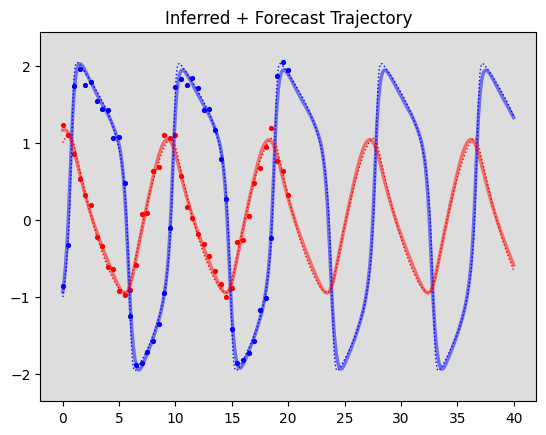

In [14]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

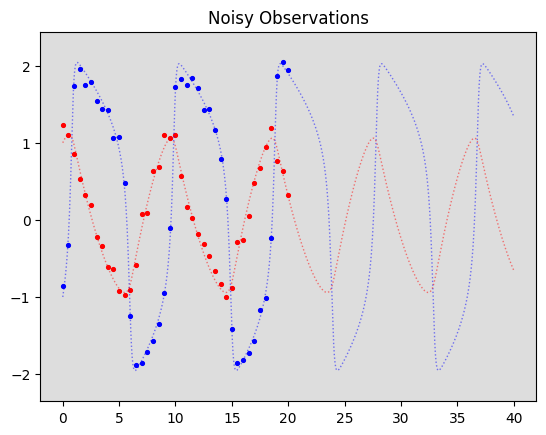

In [16]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [18]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2500,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2500 iteration: 39.367233
500/2500 iteration: 1.990714
1000/2500 iteration: 1.305106
1500/2500 iteration: 1.108004
2000/2500 iteration: 1.010481
2500/2500 iteration: 0.948814
run time: 25.00 seconds


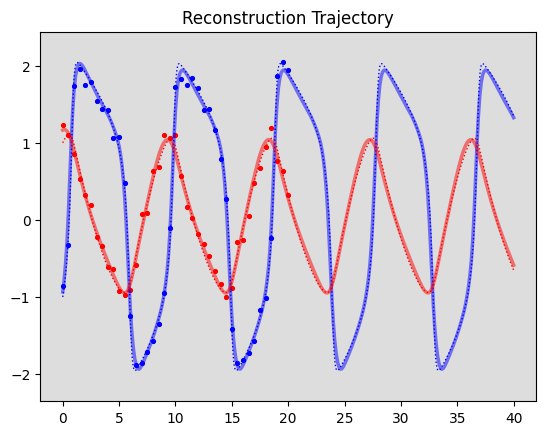

In [19]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

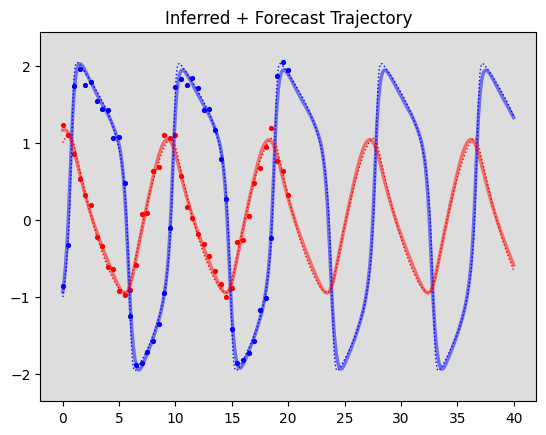

In [20]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

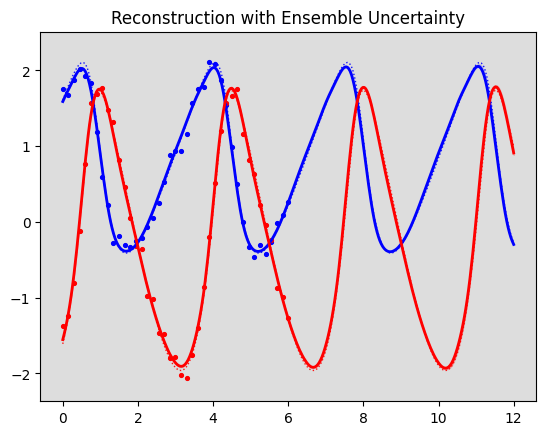

In [157]:
def fit_and_reconstruct(seed):
    torch.manual_seed(seed)
    fOde = nnMTModule(no_comp, [512], dp=0)       # your original setup
    model = FMAGI(obs, fOde, grid_size=161, interpolation_orders=3)
    _, xinfer = model.map(max_epoch=2500, learning_rate=1e-3,
                          decay_learning_rate=True, hyperparams_update=False,
                          dynamic_standardization=True, verbose=False, returnX=True)
    x0 = xinfer[0,:].squeeze()
    tr, xr = model.predict(trecon[1:], trecon[:1], x0, random=False)
    return tr, xr

trecon = tdata[np.linspace(0, tdata.size-1, 321).astype(int)]
seeds = [188714368 + k for k in range(0)]  # e.g., 20 restarts
all_xr = []
for s in seeds:
    tr_s, xr_s = fit_and_reconstruct(s)
    all_xr.append(xr_s)
all_xr = np.stack(all_xr, axis=0)  # (E, T, D)

# plot percentiles
fig, ax = plt.subplots(facecolor='w')
ax.set_facecolor('#dddddd')
col = ['b','r','g']
for i in range(no_comp):
    median = np.median(all_xr[:,:,i], axis=0)
    p10 = np.percentile(all_xr[:,:,i], 10, axis=0)
    p90 = np.percentile(all_xr[:,:,i], 90, axis=0)
    ax.fill_between(tr_s, p10, p90, color=col[i], alpha=0.2)
    ax.plot(tr_s, median, color=col[i], lw=2.0)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], lw=1.0, alpha=0.9)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, color=col[i])
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata), np.max(xdata)+0.1*np.ptp(xdata))
ax.set_title('Reconstruction with Ensemble Uncertainty')
plt.show()


In [159]:
spread_V = np.max(np.percentile(all_xr[:,:,0], 95, axis=0) - np.percentile(all_xr[:,:,0], 5, axis=0))
spread_R = np.max(np.percentile(all_xr[:,:,1], 95, axis=0) - np.percentile(all_xr[:,:,1], 5, axis=0))
print("Max 5–95% band width — V:", spread_V, " R:", spread_R)


Max 5–95% band width — V: 0.13711978755185528  R: 0.1558779773380575


1/2500 iteration: 101.711463
500/2500 iteration: 5.563286
1000/2500 iteration: 2.265002
1500/2500 iteration: 1.775506
2000/2500 iteration: 1.593156
2500/2500 iteration: 1.522203


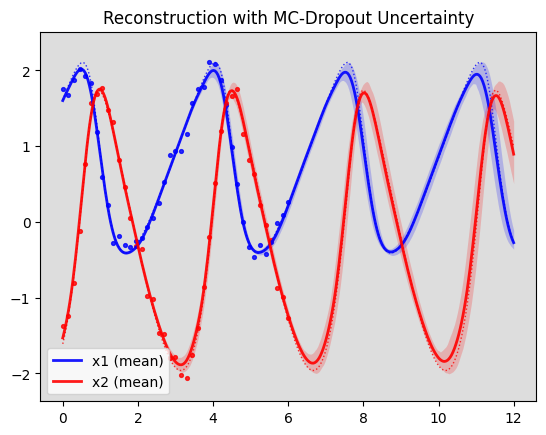

In [160]:
# 1) define with dropout BEFORE training (dp>0 enables MC-dropout)
fOde = nnMTModule(no_comp, [512], dp=0.10)   # e.g., 10% dropout
model = FMAGI(obs, fOde, grid_size=161, interpolation_orders=3)
tinfer, xinfer = model.map(max_epoch=2500, learning_rate=1e-3,
                           decay_learning_rate=True,
                           hyperparams_update=False,
                           dynamic_standardization=True,
                           verbose=True, returnX=True)

# 2) sample multiple reconstructions with dropout active
trecon = tdata[np.linspace(0, tdata.size-1, 321).astype(int)]
x0 = xinfer[0, :].squeeze()

S = 200  # number of MC samples
samples = []
for s in range(S):
    tr_s, xr_s = model.predict(trecon[1:], trecon[:1], x0, random=True)  # dropout ON
    samples.append(xr_s)
samples = np.stack(samples, axis=0)  # (S, T, D)

# 3) compute bands and plot
col = ['b', 'r', 'g']
fig, ax = plt.subplots(facecolor='w')
ax.set_facecolor('#dddddd')
for i in range(no_comp):
    mean = samples[:,:,i].mean(axis=0)
    p05  = np.percentile(samples[:,:,i], 5, axis=0)
    p95  = np.percentile(samples[:,:,i], 95, axis=0)
    ax.fill_between(tr_s, p05, p95, color=col[i], alpha=0.2, linewidth=0)   # 90% band
    ax.plot(tr_s, mean, color=col[i], lw=2.0, alpha=0.9, label=f'x{i+1} (mean)')
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], lw=1.0, alpha=0.8)  # truth
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, color=col[i], alpha=0.8)
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata), np.max(xdata)+0.1*np.ptp(xdata))
ax.set_title('Reconstruction with MC-Dropout Uncertainty')
ax.legend()
plt.show()


In [161]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_magix_main_with_calibration(
    t_recon,            # 1D array, time grid matching all_xr's T
    all_xr,             # (E, T, D) ensemble of reconstructions
    tdata,              # 1D array, original simulation time grid
    xdata,              # (N, D) ground truth on tdata
    obs,                # list of length D; each is (n_i, 2): [time, value]
    names=('V','R'),    # component names
    train_fraction=0.5, # used if split_time not provided
    split_time=None,    # or specify explicit split time
    qs=(5,25,50,75,95), # percentiles for ribbons/median
    figsize=(7.2, 5.4),
    savepath=None,
    title='Reconstruction with Uncertainty (50% & 90%)'
):
    """
    Returns (fig, axes). Saves to savepath if provided.
    """
    assert all_xr.ndim == 3, "all_xr must be (E, T, D)"
    E, T, D = all_xr.shape
    assert len(t_recon) == T, "t_recon length must match all_xr.shape[1]"
    assert xdata.shape[1] >= D, "xdata must have >= D columns"

    # map truth to the reconstruction grid
    idx = np.searchsorted(tdata, t_recon)
    xtrue = xdata[idx, :D]  # (T, D)

    # choose train/test split
    if split_time is None:
        split_idx = int(T * train_fraction)
    else:
        split_idx = int(np.searchsorted(t_recon, split_time))
    split_idx = np.clip(split_idx, 1, T-1)

    # global percentiles once (5,25,50,75,95)
    P = np.percentile(all_xr, np.array(qs), axis=0)  # (5, T, D)
    # helpers
    def rmse(yhat, y):
        return float(np.sqrt(np.mean((yhat - y)**2)))
    def coverage(y, lo, hi):
        return float(np.mean((y >= lo) & (y <= hi)))

    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
    fig, axes = plt.subplots(D, 1, figsize=figsize, sharex=True)
    if D == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        # ribbons
        p5, p25, p50, p75, p95 = P[0,:,i], P[1,:,i], P[2,:,i], P[3,:,i], P[4,:,i]
        ax.fill_between(t_recon, p5,  p95, color=colors[i], alpha=0.20, linewidth=0, zorder=1)  # 90%
        ax.fill_between(t_recon, p25, p75, color=colors[i], alpha=0.35, linewidth=0, zorder=2)  # 50%
        # median
        ax.plot(t_recon, p50, color=colors[i], lw=2.2, zorder=3, label=f'{names[i]} median')
        # truth
        ax.plot(t_recon, xtrue[:,i], ls='--', lw=1.2, color=colors[i], alpha=0.9, zorder=2.5, label='truth')
        # observations
        if obs is not None and len(obs) > i and obs[i] is not None:
            ax.scatter(obs[i][:,0], obs[i][:,1], s=12, color=colors[i],
                       edgecolor='white', linewidth=0.4, zorder=4, label='obs')

        # train/forecast separator
        ax.axvline(t_recon[split_idx], color='k', lw=1, alpha=0.6, zorder=5)
        ax.axvspan(t_recon[split_idx], t_recon[-1], color='k', alpha=0.05, zorder=0)

        # metrics (per panel)
        rmse_tr = rmse(p50[:split_idx], xtrue[:split_idx, i])
        rmse_te = rmse(p50[split_idx:], xtrue[split_idx:, i])
        cov90_tr = coverage(xtrue[:split_idx, i], p5[:split_idx],  p95[:split_idx])
        cov90_te = coverage(xtrue[split_idx:, i], p5[split_idx:], p95[split_idx:])
        ax.text(0.01, 0.97,
                f'RMSE train: {rmse_tr:.3f}\nRMSE test: {rmse_te:.3f}\n90% cov. train: {cov90_tr:.2f}\n90% cov. test: {cov90_te:.2f}',
                transform=ax.transAxes, ha='left', va='top', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='0.7', alpha=0.95))
        ax.set_ylabel(names[i])
        ax.grid(False)

    axes[-1].set_xlabel('time')
    if title:
        fig.suptitle(title, y=0.98)

    # ---- Calibration inset (test region): empirical coverage vs nominal ----
    qs_nominal = np.arange(10, 95, 10)  # 10%,20%,...,90%
    # compute empirical coverage on test slice for each component
    cov_curves = np.zeros((len(qs_nominal), D))
    te = slice(split_idx, None)
    for j, q in enumerate(qs_nominal):
        lo = np.percentile(all_xr[:, :, :], 50 - q/2, axis=0)[te, :]  # (T_te, D)
        hi = np.percentile(all_xr[:, :, :], 50 + q/2, axis=0)[te, :]
        inside = (xtrue[te, :] >= lo) & (xtrue[te, :] <= hi)
        cov_curves[j, :] = inside.mean(axis=0)

    # put one inset on the top axis
    ax_in = inset_axes(axes[0], width="42%", height="42%", loc='upper right',
                       bbox_to_anchor=(0,0,1,1), bbox_transform=axes[0].transAxes, borderpad=1.0)
    ax_in.plot([0,1], [0,1], 'k--', lw=1, alpha=0.7, label='ideal')
    for i in range(D):
        ax_in.plot(qs_nominal/100.0, cov_curves[:, i],
                   marker='o', lw=1.5, ms=3.0, label=f'{names[i]} (test)', color=colors[i])
    ax_in.set_xlim(0,1); ax_in.set_ylim(0,1)
    ax_in.set_xlabel('nominal', fontsize=8); ax_in.set_ylabel('empirical', fontsize=8)
    ax_in.tick_params(labelsize=8)
    ax_in.legend(fontsize=7, loc='lower right', frameon=True)

    fig.tight_layout(rect=[0,0,1,0.97])
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches='tight')
    return fig, axes

# ---- Example call (using your variables) ----
# E x T x D ensemble in `all_xr`, time in `trecon`, truth in (tdata,xdata), observations in `obs`
# fig, axes = plot_magix_main_with_calibration(trecon, all_xr, tdata, xdata, obs,
#                                              train_fraction=0.5,
#                                              savepath='fig_fn_uq.pdf',
#                                              title='FitzHugh–Nagumo: MAGI-X Reconstruction with UQ')
# plt.show()


In [162]:
# ---- Example call (using your variables) ----
E x T x D ensemble in `all_xr`, time in `trecon`, truth in (tdata,xdata), observations in `obs`
fig, axes = plot_magix_main_with_calibration(trecon, all_xr, tdata, xdata, obs,
                                             train_fraction=0.5,
                                             savepath='fig_fn_uq.pdf',
                                             title='FitzHugh–Nagumo: MAGI-X Reconstruction with UQ')
plt.show()


SyntaxError: invalid syntax (3245525293.py, line 2)

### Hes1

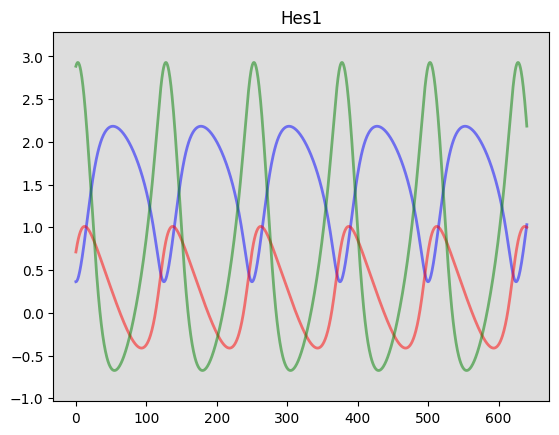

In [34]:
# define Hes1 model dynamic
def fOde(y, t, a, b, c, d, e, f, g):
	P, M, H = y
	dPdt = -a*P*H + b*M - c*P
	dMdt = -d*M + e/(1+np.power(P,2))
	dHdt = -a*P*H + f/(1+np.power(P,2)) - g*H
	return (dPdt,dMdt,dHdt)

# model parameters
a, b, c, d, e, f, g = 0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3
# initial condition
P0, M0, R0 = 1.438575, 2.037488, 17.90385
y0 = P0, M0, R0
# time point for evaluation
tdata = np.linspace(0, 640, 1281)
# integration 
xdata = odeint(fOde, y0, tdata, args = (a,b,c,d,e,f,g))
xdata = np.log(xdata)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='P')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='M')
ax.plot(tdata, xdata[:,2], 'g', alpha=0.5, lw=2, label='H')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Hes1')
plt.show()

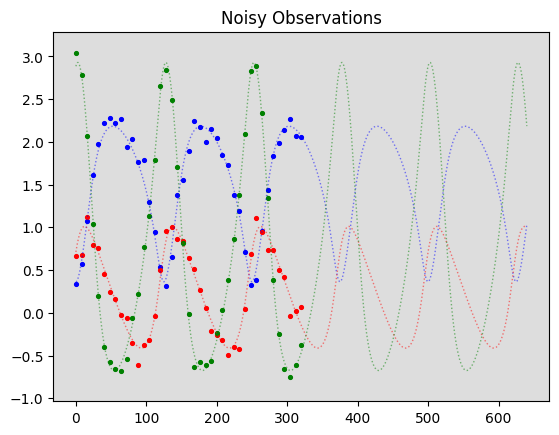

In [138]:
# setting
seed = 305321902 # random seed
noise = [0.1,0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [139]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2500,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2500 iteration: 17.716463
500/2500 iteration: 2.705479
1000/2500 iteration: 2.162013
1500/2500 iteration: 1.934160
2000/2500 iteration: 1.769941
2500/2500 iteration: 1.637808
run time: 100.25 seconds


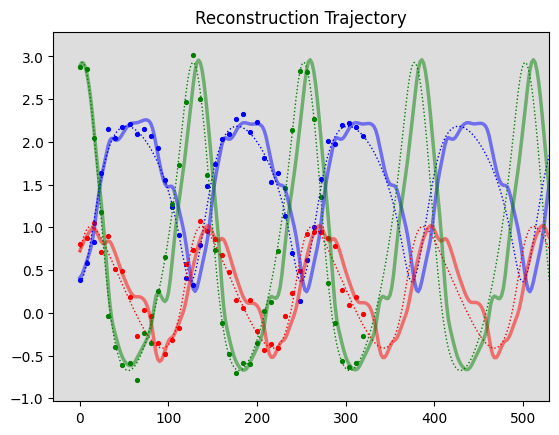

In [133]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
# trecon = tdata[np.linspace(0,161,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(-30, 530)
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

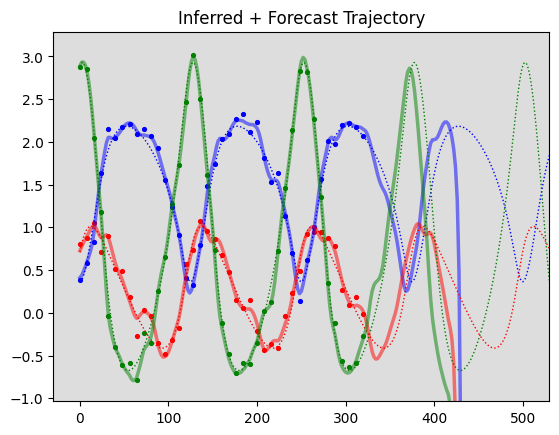

In [134]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(-30, 530)
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

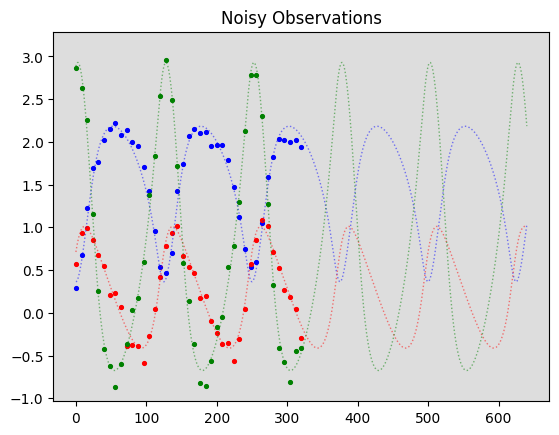

In [144]:
# setting
seed = 18871438 # random seed
noise = [0.10,0.10,0.10] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [145]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 10.919912
200/1000 iteration: 2.703710
400/1000 iteration: 2.055629
600/1000 iteration: 1.924986
800/1000 iteration: 1.846546
1000/1000 iteration: 1.777886
run time: 48.81 seconds


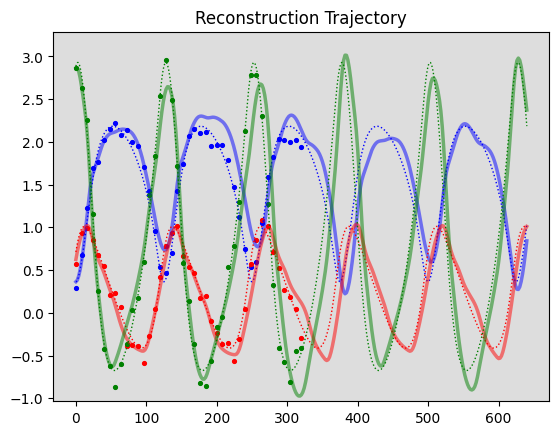

In [146]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

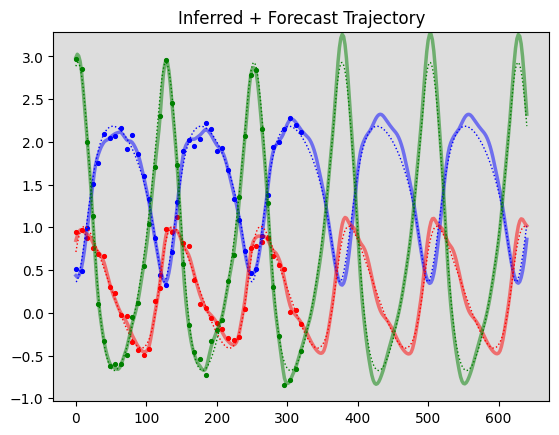

In [143]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

### Lorenz 96

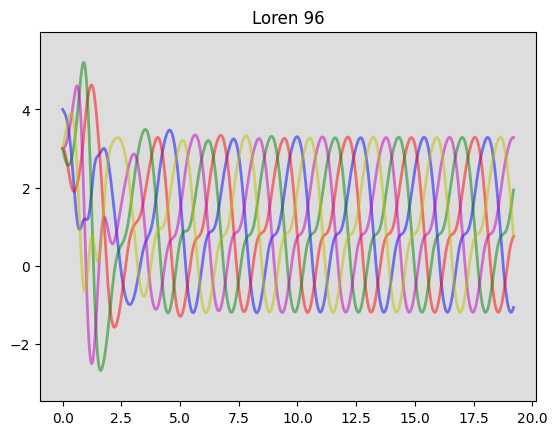

In [30]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 19.2, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

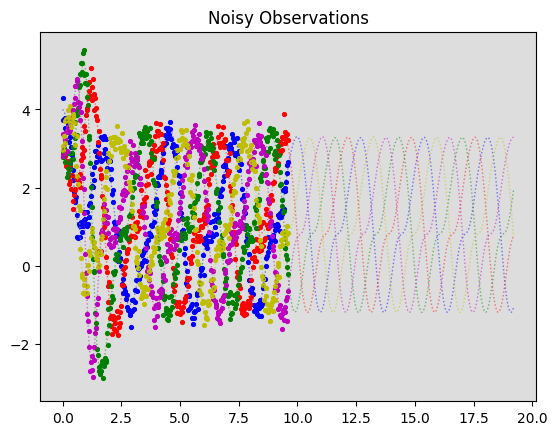

In [31]:
# setting
seed = 188714368 # random seed
noise = [0.2] * xdata.shape[1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [33]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 29.881064
200/1000 iteration: 9.023293
400/1000 iteration: 5.690324
600/1000 iteration: 4.525343
800/1000 iteration: 4.027912
1000/1000 iteration: 3.788589
run time: 40.62 seconds


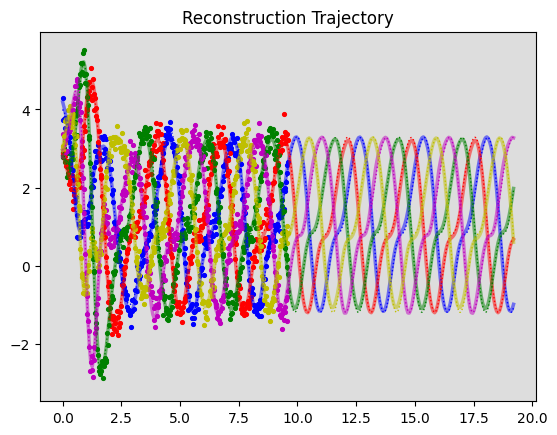

In [34]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

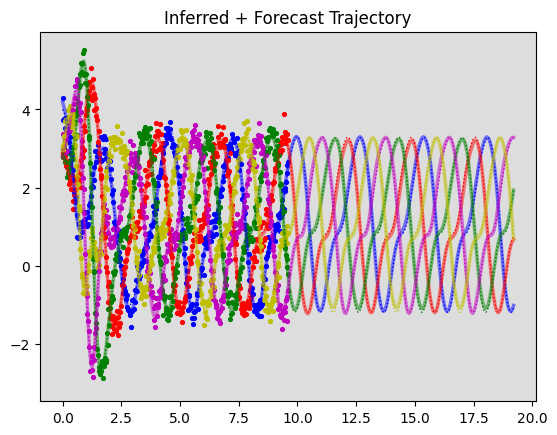

In [35]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

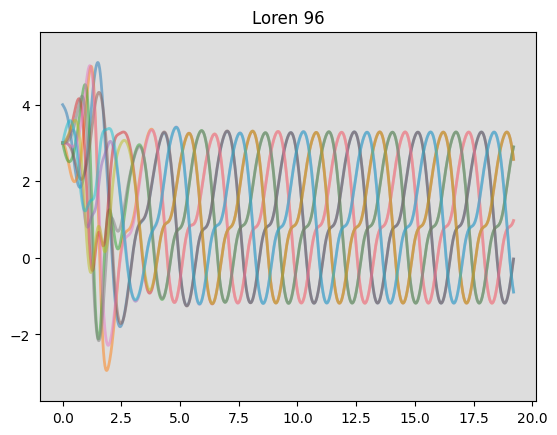

In [37]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(10)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 19.2, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

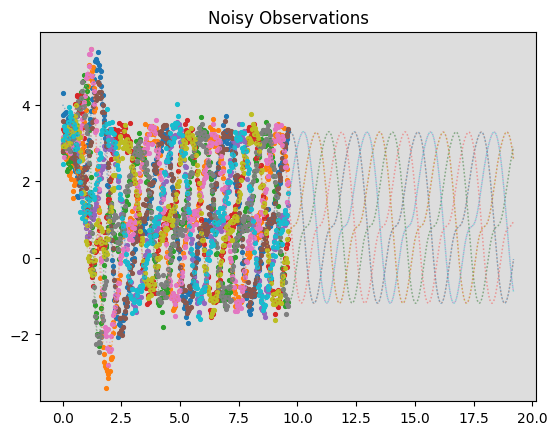

In [40]:
# setting
seed = 188714368 # random seed
noise = [0.2] * xdata.shape[1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [48]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 48.314856
200/1000 iteration: 14.229198
400/1000 iteration: 9.202411
600/1000 iteration: 7.669826
800/1000 iteration: 7.078608
1000/1000 iteration: 6.818216
run time: 76.99 seconds


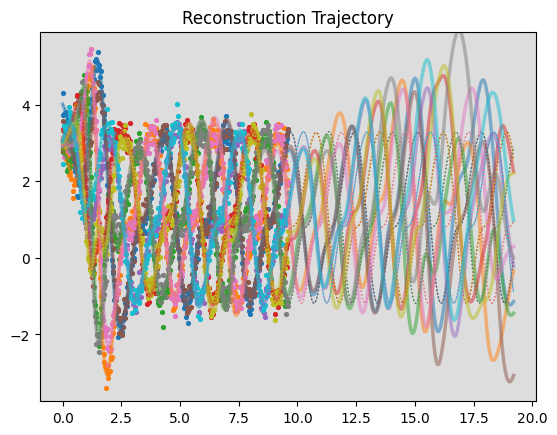

In [49]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

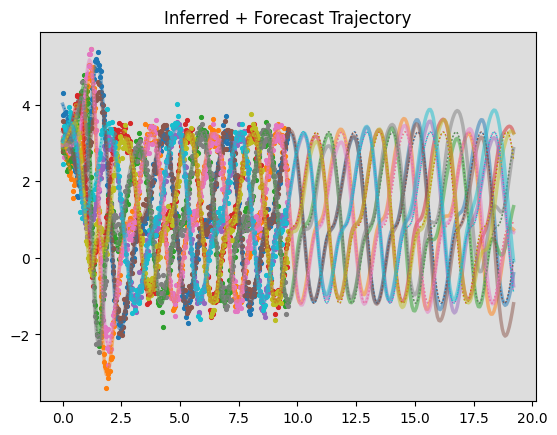

In [50]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

### ILI

In [51]:
ili = pd.read_csv("data/national_illness_region.csv")
ili.head()

date  weighted_ili_National  weighted_ili_Region 1  \
0   9/28/1997                1.10148               0.498535   
1   10/5/1997                1.20007               0.642669   
2  10/12/1997                1.37876               2.899080   
3  10/19/1997                1.19920               4.812500   
4  10/26/1997                1.65618               1.371360   

   weighted_ili_Region 2  weighted_ili_Region 3  weighted_ili_Region 4  \
0               0.374963               1.354280               0.400338   
1               0.315666               1.479780               1.423890   
2               0.310564               2.635980               0.966721   
3               0.325144               1.983990               0.574446   
4               3.758060               0.750464               1.224550   

   weighted_ili_Region 5  weighted_ili_Region 6  weighted_ili_Region 7  \
0               1.229260                1.01898               0.871791   
1               1.136000                1.44932               0.449154   
2               1.023580                1.46230               0.346781   
3               0.806177                1.64702               0.647388   
4               1.096170                2.46072               0.492672   

   weighted_ili_Region 8  ...  unweighted_ili_Region 1  \
0               0.516017  ...                 0.623848   
1               0.503080  ...                 0.815801   
2               0.176081  ...                 1.225840   
3               0.796463  ...                 1.621690   
4               0.186496  ...                 0.780165   

   unweighted_ili_Region 2  unweighted_ili_Region 3  unweighted_ili_Region 4  \
0                 0.384615                  1.34172                 0.450010   
1                 0.229358                  1.53285                 0.389036   
2                 0.127226                  2.18735                 0.467532   
3                 0.223714                  1.69761                 0.169525   
4                 2.886600                  1.05062                 0.474247   

   unweighted_ili_Region 5  unweighted_ili_Region 6  unweighted_ili_Region 7  \
0                 0.901266                 0.747384                 1.152860   
1                 1.081310                 0.877193                 0.647948   
2                 1.064500                 0.899550                 0.607477   
3                 1.001620                 1.059000                 0.688172   
4                 1.349670                 1.694920                 0.500835   

   unweighted_ili_Region 8  unweighted_ili_Region 9  unweighted_ili_Region 10  
0                 0.422654                  2.25878                  4.825400  
1                 0.717703                  2.56626                  3.959130  
2                 0.246711                  2.41531                  2.175970  
3                 0.417537                  2.64035                  0.609418  
4                 0.345871                  3.15138                  1.114650  

[5 rows x 23 columns]

<AxesSubplot:xlabel='date'>

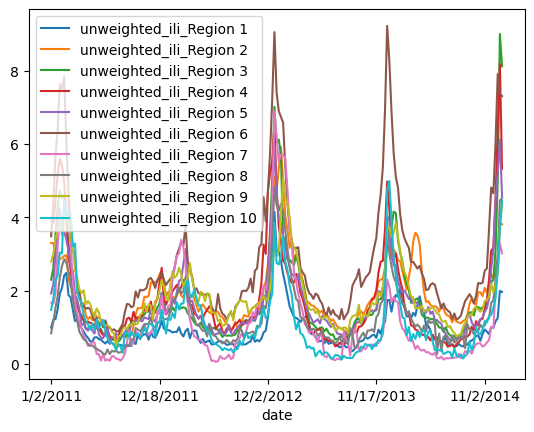

In [52]:
# 2011 - 2014
ili_sub = ili.iloc[692:901,:].copy().reset_index(drop=True)
ili_sub.plot(x='date', y=[f'unweighted_ili_Region {i}' for i in range(1,11)])

In [76]:
# first two year for training, unweighted 
tmax = len(ili_sub)
tdata = np.arange(tmax)
xdata_10 = ili_sub.iloc[:tmax,13:23].to_numpy()
xdata = np.zeros((len(xdata_10),4))
xdata[:,0] = np.mean(xdata_10[:,[0,1,2]], axis=1) # northeast
xdata[:,1] = np.mean(xdata_10[:,[4,6]], axis=1) # midwest
xdata[:,2] = np.mean(xdata_10[:,[3,5]], axis=1) # south
xdata[:,3] = np.mean(xdata_10[:,[7,8,9]], axis=1) # west
xdata = np.log(xdata)
no_comp = xdata.shape[1]
tmax_train = 150 # 105
obs = [] # set random seed for noise
for i in range(no_comp):
    tobs = tdata[:tmax_train].copy()
    yobs = xdata[:tmax_train,i].copy()
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

In [77]:
# MAP Inference - Multi Task Neural Network
seed = 188714368
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=201,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=True, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2000 iteration: 98.500883
400/2000 iteration: 16.133159
800/2000 iteration: 9.266745
1200/2000 iteration: 7.320846
1600/2000 iteration: 6.481387
2000/2000 iteration: 6.014690
run time: 98.79 seconds


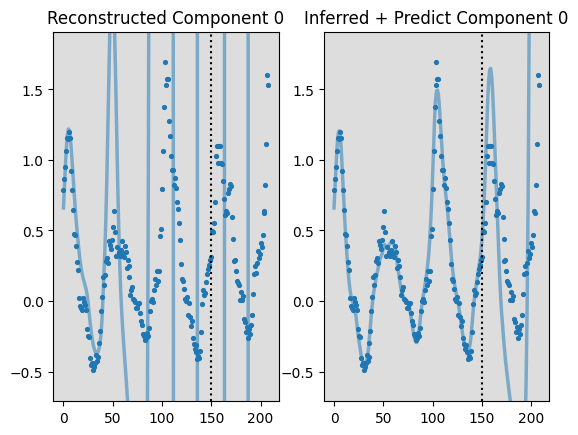

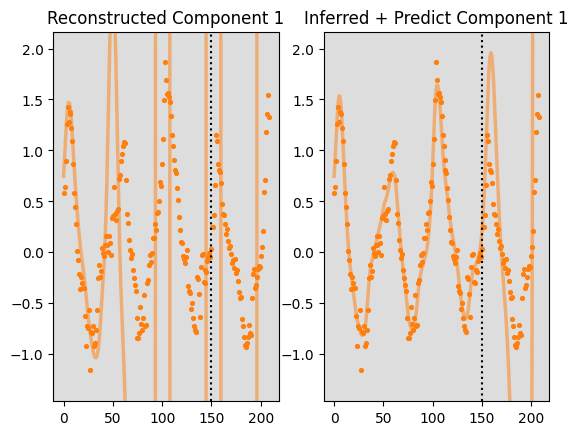

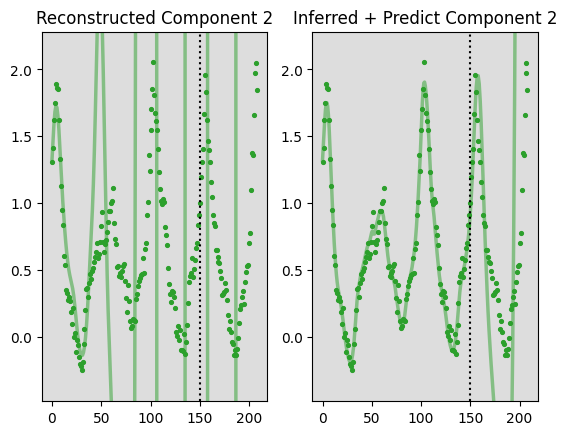

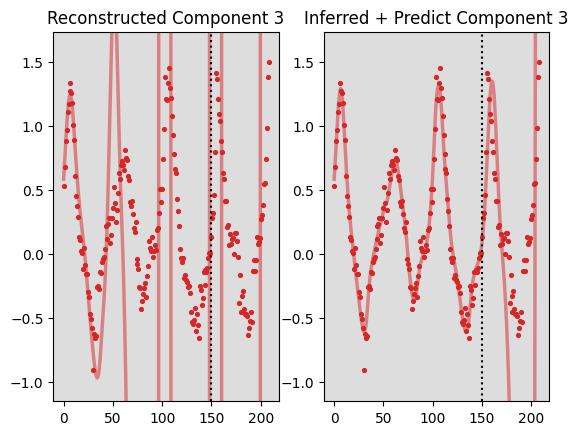

In [78]:
# reconstruction with ode numerical integration
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
tpred = tdata[tmax_train:]
tp, xp = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
col = list(mcolors.TABLEAU_COLORS.values())
for i in range(no_comp):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(121, facecolor='#dddddd', axisbelow=True)
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
    plt.title(f'Reconstructed Component {i}')
    ax = fig.add_subplot(122, facecolor='#dddddd', axisbelow=True)
    ax.plot(tp, xp[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
    plt.title(f'Inferred + Predict Component {i}')
    plt.show()

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


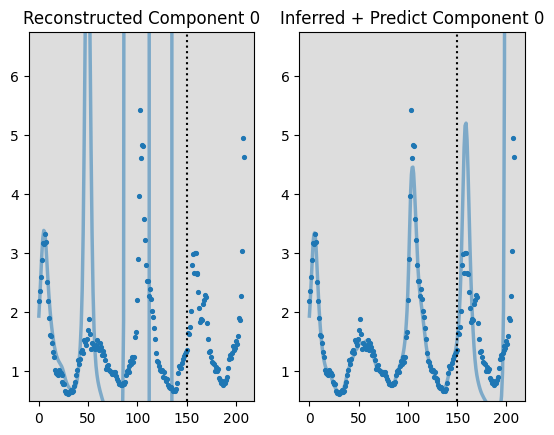

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


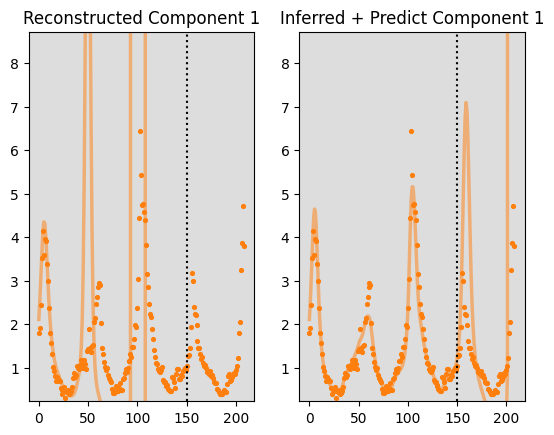

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


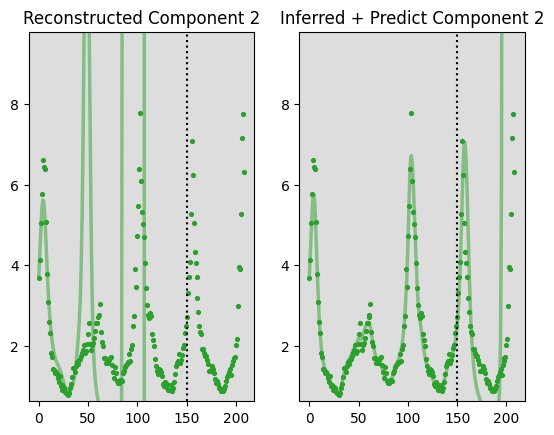

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


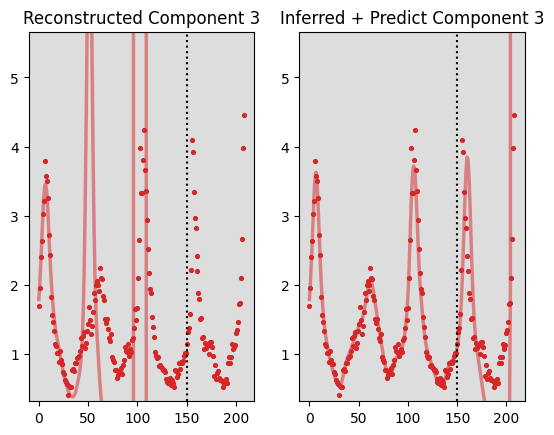

In [79]:
# reconstruction with ode numerical integration
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
tpred = tdata[tmax_train:]
tp, xp = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
col = list(mcolors.TABLEAU_COLORS.values())
for i in range(no_comp):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(121, facecolor='#dddddd', axisbelow=True)
    ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, np.exp(xdata[:,i]), s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.exp(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i])),np.exp(np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i])))
    plt.title(f'Reconstructed Component {i}')
    ax = fig.add_subplot(122, facecolor='#dddddd', axisbelow=True)
    ax.plot(tp, np.exp(xp[:,i]), color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, np.exp(xdata[:,i]), s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.exp(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i])),np.exp(np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i])))
    plt.title(f'Inferred + Predict Component {i}')
    plt.show()

### LV


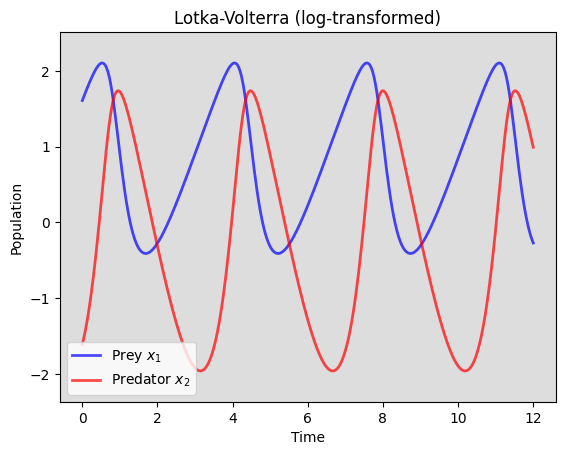

In [151]:

# define Lotka-Volterra dynamics (log-transformed)
def LV_log(y, t, a, b, c, d):
    x1, x2 = np.exp(y)   # work in original space
    dx1dt = a*x1 - b*x1*x2
    dx2dt = c*x1*x2 - d*x2
    return [dx1dt/x1, dx2dt/x2]  # chain rule for log transform

# model parameters
a, b, c, d = 1.5, 1.0, 1.0, 3.0
# initial condition in log-space
x1_0, x2_0 = 5.0, 0.2
y0 = np.log([x1_0, x2_0])

# time points (similar to paper: up to ~12 with 321 points)
tdata = np.linspace(0, 12, 321)

# integration
ydata = odeint(LV_log, y0, tdata, args=(a, b, c, d))
xdata = ydata  # back-transform to original space for plotting

# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, ydata[:,0], 'b', alpha=0.7, lw=2, label='Prey $x_1$')
ax.plot(tdata, ydata[:,1], 'r', alpha=0.7, lw=2, label='Predator $x_2$')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_ylim(np.min(ydata) - 0.1*np.ptp(ydata),
            np.max(ydata) + 0.1*np.ptp(ydata))
ax.legend()
plt.title('Lotka-Volterra (log-transformed)')
plt.show()


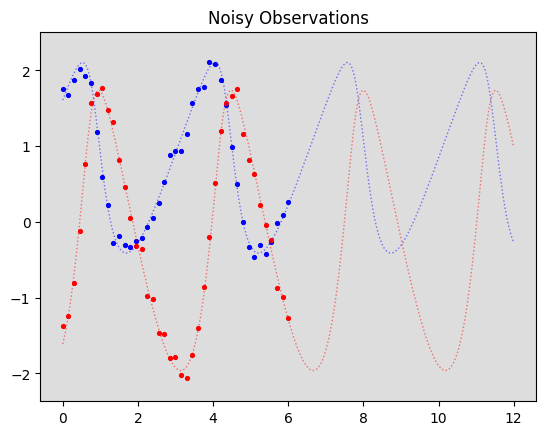

In [153]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [154]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2500,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2500 iteration: 97.889137
500/2500 iteration: 5.176450
1000/2500 iteration: 2.104687
1500/2500 iteration: 1.622856
2000/2500 iteration: 1.462085
2500/2500 iteration: 1.390385
run time: 25.32 seconds


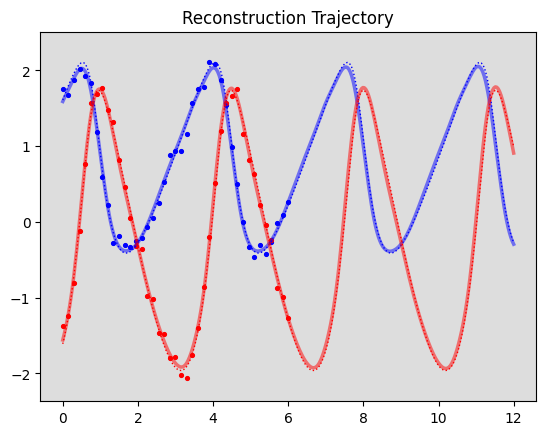

In [155]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

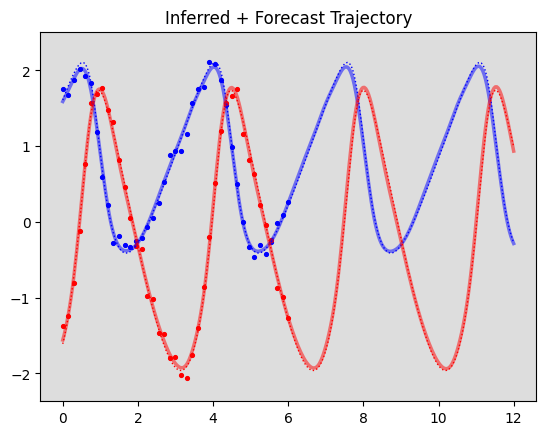

In [156]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()